# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

#### Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

#### Целевой признак
- Exited — факт ухода клиента

### План работы над проектом

1. Изучить данные. Разбить данные на тренировочную, валидационную и тестовую выборку.
2. Исследовать задачу. Проверить модели на данных без изменений.
3. Скоректировать балланс класса. Изменить вес класса, урезать 0 или добавить 1.
4. Получить улученную модель. Провести поиск гиперпараметров.
5. Провести финальный тест.
6. Написать вывод и оформить проект.

# 1. Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

In [2]:
churn_data = pd.read_csv('/datasets/Churn.csv')
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
def check_columns(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
        
check_columns(churn_data)

Уникальные значения столбца RowNumber
[    1     2     3 ...  9998  9999 10000]
Уникальные значения столбца CustomerId
[15634602 15647311 15619304 ... 15584532 15682355 15628319]
Уникальные значения столбца Surname
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Уникальные значения столбца CreditScore
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 61

Заменим все NaN из столбца Tenure на 0. Если жилье не указано, скорей всего его нет.

In [4]:
churn_data['Tenure'] = churn_data['Tenure'].fillna(0)
churn_data.isna().mean()

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [5]:
churn_data['Tenure'].value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: Tenure, dtype: int64

Удалим столбецы RowNumber, CustomerId и Surname. Они не нужны при исследовании модели. 

RowNumber повторяет индекс датафрейма, CustomerId - случайный или последовательный номер, который никак не зависит от действий пользователя. Surname - признак, который отличается от человека к человеку и является именем в обществе. Это не гарант того, что клиент останется или уйдет.

In [6]:
churn_data = churn_data.drop(['RowNumber','CustomerId','Surname'], axis=1)
churn_data.shape

(10000, 11)

Создадим датафрейм, созданный по методу прямого кодирования с защитой от дамми-ловушки.

In [7]:
ohe_churn_data = pd.get_dummies(churn_data, drop_first=True)
ohe_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


### Вывод по шагу 1

Данные готовы к исследованию.

Были удалены не влияющие на конечный фактор данные. Мы создаем модель классификации, который нужно отдать признаки, реально влияющие на суть дела.

# 2. Исследование задачи

Будем использовать следующие модели:
- Логистическая регрессия
- Случайный лес
- Решающее дерево
- GaussianNB

Разобъем данные по принципу 60/20/20.

In [8]:
target = ohe_churn_data['Exited']
features = ohe_churn_data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=20052020)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=20052020 )
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


Посмотрим, какой существует дисбаланс классов.

In [9]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Соотношение классов 1:4. Изучим модели без исправление баланса.

Начнем с решающего дерева. Проведем исследование при разном значении max_depth.

In [10]:
%%time

for depth in range(2, 30):
    model = DecisionTreeClassifier(random_state=20052020, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('Max depth', depth,'F1-score', f1_score(target_valid, predicted_valid))

Max depth 2 F1-score 0.5247813411078718
Max depth 3 F1-score 0.5514285714285715
Max depth 4 F1-score 0.49185667752443
Max depth 5 F1-score 0.5421686746987953
Max depth 6 F1-score 0.5852272727272727
Max depth 7 F1-score 0.6134453781512604
Max depth 8 F1-score 0.5632183908045977
Max depth 9 F1-score 0.583883751651255
Max depth 10 F1-score 0.5511811023622049
Max depth 11 F1-score 0.5487179487179488
Max depth 12 F1-score 0.5363984674329502
Max depth 13 F1-score 0.5088607594936709
Max depth 14 F1-score 0.5153374233128835
Max depth 15 F1-score 0.5198555956678701
Max depth 16 F1-score 0.5117370892018779
Max depth 17 F1-score 0.5179190751445086
Max depth 18 F1-score 0.5228604923798359
Max depth 19 F1-score 0.48786127167630056
Max depth 20 F1-score 0.49709639953542395
Max depth 21 F1-score 0.491186839012926
Max depth 22 F1-score 0.4872389791183295
Max depth 23 F1-score 0.5022935779816514
Max depth 24 F1-score 0.48561565017261216
Max depth 25 F1-score 0.5034802784222738
Max depth 26 F1-score 0.5

Лучший реультат был достигнут на глубине 7.

Рассмотрим, как себя ведет случайный лес. И проведем исследование на разное количество деревьев.

In [11]:
%%time

for estimator in range(50, 300, 10):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid))

N estimators 50 F1 0.6235955056179775
N estimators 60 F1 0.6234132581100141
N estimators 70 F1 0.6207865168539325
N estimators 80 F1 0.6156028368794326
N estimators 90 F1 0.612994350282486
N estimators 100 F1 0.6160337552742616
N estimators 110 F1 0.6143057503506311
N estimators 120 F1 0.6145251396648045
N estimators 130 F1 0.6125874125874126
N estimators 140 F1 0.6106442577030813
N estimators 150 F1 0.6100278551532032
N estimators 160 F1 0.6145251396648045
N estimators 170 F1 0.6128133704735377
N estimators 180 F1 0.6155988857938718
N estimators 190 F1 0.6119610570236439
N estimators 200 F1 0.6181818181818182
N estimators 210 F1 0.6175243393602226
N estimators 220 F1 0.6175243393602226
N estimators 230 F1 0.6213592233009709
N estimators 240 F1 0.6194444444444445
N estimators 250 F1 0.6203059805285119
N estimators 260 F1 0.6166666666666667
N estimators 270 F1 0.6166666666666667
N estimators 280 F1 0.6203059805285119
N estimators 290 F1 0.6194444444444445
CPU times: user 41.1 s, sys: 32

Лучший результат был получен в районе 50-60 n_estimators. Сделаем исследование с шагом 1.

In [12]:
%%time

for estimator in range(40, 61, 1):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid))

N estimators 40 F1 0.6140845070422536
N estimators 41 F1 0.6185852981969486
N estimators 42 F1 0.6162464985994398
N estimators 43 F1 0.6155988857938718
N estimators 44 F1 0.6160337552742616
N estimators 45 F1 0.6145251396648045
N estimators 46 F1 0.6123595505617977
N estimators 47 F1 0.6164574616457461
N estimators 48 F1 0.615819209039548
N estimators 49 F1 0.6213592233009709
N estimators 50 F1 0.6235955056179775
N estimators 51 F1 0.6222222222222222
N estimators 52 F1 0.6246498599439776
N estimators 53 F1 0.6248256624825662
N estimators 54 F1 0.6227208976157083
N estimators 55 F1 0.6239554317548746
N estimators 56 F1 0.6186440677966101
N estimators 57 F1 0.6201117318435754
N estimators 58 F1 0.6227208976157083
N estimators 59 F1 0.6211699164345404
N estimators 60 F1 0.6234132581100141
CPU times: user 10.3 s, sys: 56 ms, total: 10.4 s
Wall time: 10.5 s


Лучший результат по гиперпараметру n_estimators достигнут на 53.

Исследуем, как работает Логистическая регрессия на этих данных.

In [13]:
%%time

model =  LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid))

F1 0.09224318658280924
CPU times: user 85.4 ms, sys: 20.3 ms, total: 106 ms
Wall time: 108 ms


Результаты довольно низкие. Возможно precision или recall низкий и близок к 0.

Рассмотрим как работает Гаусовская байсовая модель.

In [14]:
%%time

model =  GaussianNB()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid))

F1 0.11507936507936507
CPU times: user 8.41 ms, sys: 2.82 ms, total: 11.2 ms
Wall time: 9.13 ms


Похожий результат, как и логистической регресии.

Проведем оценку accuracy,  precision и recall, также покажем F-метрику.

In [15]:
%%time

model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = GaussianNB()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Гаусовская байсовая модель')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Точность попадания по классам 0.862
Precision 0.773851590106007
Recall 0.5081206496519721
F1 0.6134453781512604

Случайный лес
Точность попадания по классам 0.8655
Precision 0.7832167832167832
Recall 0.5197215777262181
F1 0.6248256624825662

Логистическая регрессия
Точность попадания по классам 0.7835
Precision 0.4782608695652174
Recall 0.05104408352668213
F1 0.09224318658280924

Гаусовская байсовая модель
Точность попадания по классам 0.777
Precision 0.3972602739726027
Recall 0.06728538283062645
F1 0.11507936507936507

CPU times: user 694 ms, sys: 76.6 ms, total: 771 ms
Wall time: 788 ms


Проведем построение ROC-кривой для кажддой модели. И выведем показатель AUC-ROC.

AUC-ROC DecisionTreeClassifier 0.8421275614095016
AUC-ROC RandomForestClassifier 0.8448706744213215
AUC-ROC LogisticRegression 0.682924232408956
AUC-ROC GaussianNB 0.7545690207160485


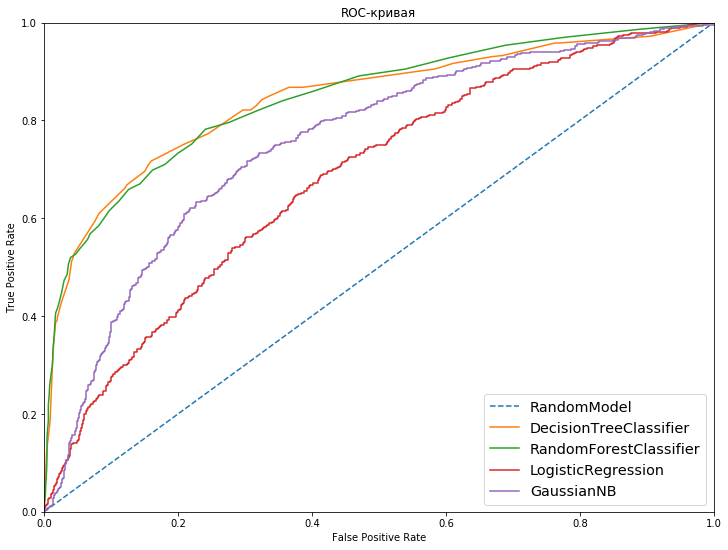

In [16]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = GaussianNB()
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC GaussianNB',auc_roc)
plt.plot(fpr, tpr, label='GaussianNB')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

По полученным реззультатам можно заменить, что метрика f1 и AUC-ROC лучшая на случаном лесе.

### Вывод по шагу 2

В данных сущестует дисбаланс классов в отношении 1:4.

Возможно он влияет на качество изучаемых моделей.

Все модели имеют recall ниже, чем percision, из-за перекоса данных, что влияет на F-меру.

# 3. Борьба с дисбалансом

Для борьбы с дисбалансом выполним сравнение моделей:
- С взвешенными классами
- С уменьшенной выборкой
- С увеличенной выборкой

Изучим возможности моделей по взвешиванию классов.

In [17]:
%%time

model = DecisionTreeClassifier(random_state=20052020, max_depth=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

# у выбранной модели нет возможности взвешивать классы
# model = GaussianNB()
# model.fit(features_train, target_train)
# predicted_valid = model.predict(features_valid)
# print('Гаусовская байсовая модель')
# print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
# print('Precision', precision_score(target_valid, predicted_valid))
# print('Recall', recall_score(target_valid, predicted_valid))
# print('F1', f1_score(target_valid, predicted_valid))
# print()

Решающее дерево
Точность попадания по классам 0.7535
Precision 0.45646067415730335
Recall 0.7540603248259861
F1 0.568678915135608

Случайный лес
Точность попадания по классам 0.8635
Precision 0.8110236220472441
Recall 0.4779582366589327
F1 0.6014598540145986

Логистическая регрессия
Точность попадания по классам 0.7015
Precision 0.3954659949622166
Recall 0.728538283062645
F1 0.5126530612244897

CPU times: user 669 ms, sys: 32.6 ms, total: 701 ms
Wall time: 667 ms


F-мера упала у решающего дерева и случайного леса, но выросла в разы у логистической регресии.

Исследуем способ уменьшения значений класса 0.

In [18]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=20052020)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=20052020)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=20052020)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

1    1202
0    1200
Name: Exited, dtype: int64


In [19]:
%%time

model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = GaussianNB()
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Гаусовская байсовая модель')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Точность попадания по классам 0.7695
Precision 0.47706422018348627
Recall 0.7238979118329466
F1 0.5751152073732718

Случайный лес
Точность попадания по классам 0.7825
Precision 0.49701492537313435
Recall 0.7726218097447796
F1 0.6049046321525886

Логистическая регрессия
Точность попадания по классам 0.6575
Precision 0.35469107551487417
Recall 0.7192575406032483
F1 0.47509578544061315

Гаусовская байсовая модель
Точность попадания по классам 0.7015
Precision 0.391644908616188
Recall 0.6960556844547564
F1 0.5012531328320802

CPU times: user 378 ms, sys: 113 ms, total: 491 ms
Wall time: 483 ms


Показатели логистической регрессии и гаусовской модели выросли. Решающее дерево и случайный лес показали себя хуже.

Исследуем методы увеличения класса 1.

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.value_counts())

1    4808
0    4798
Name: Exited, dtype: int64


In [21]:
%%time

model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = GaussianNB()
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Гаусовская байсовая модель')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Точность попадания по классам 0.7535
Precision 0.45646067415730335
Recall 0.7540603248259861
F1 0.568678915135608

Случайный лес
Точность попадания по классам 0.8525
Precision 0.6827956989247311
Recall 0.5893271461716937
F1 0.6326276463262764

Логистическая регрессия
Точность попадания по классам 0.663
Precision 0.3588850174216028
Recall 0.7169373549883991
F1 0.47832817337461303

Гаусовская байсовая модель
Точность попадания по классам 0.708
Precision 0.398406374501992
Recall 0.6960556844547564
F1 0.5067567567567568

CPU times: user 956 ms, sys: 125 ms, total: 1.08 s
Wall time: 1.08 s


F-мера стала лучше у случайного леса, логистической регресии и гаусовской модели по сравнению с дисбалансными данными. 
Лучшей моделью по F-мера стал случайны лес с тренировочными данными, где увеличен класс 1.

Выведем ROC-кривую и AUC-ROC для посленнего измененного баланса.

AUC-ROC DecisionTreeClassifier 0.8241753285450855
AUC-ROC RandomForestClassifier 0.852428653183268
AUC-ROC LogisticRegression 0.7291430988156554
AUC-ROC GaussianNB 0.7548440714007917


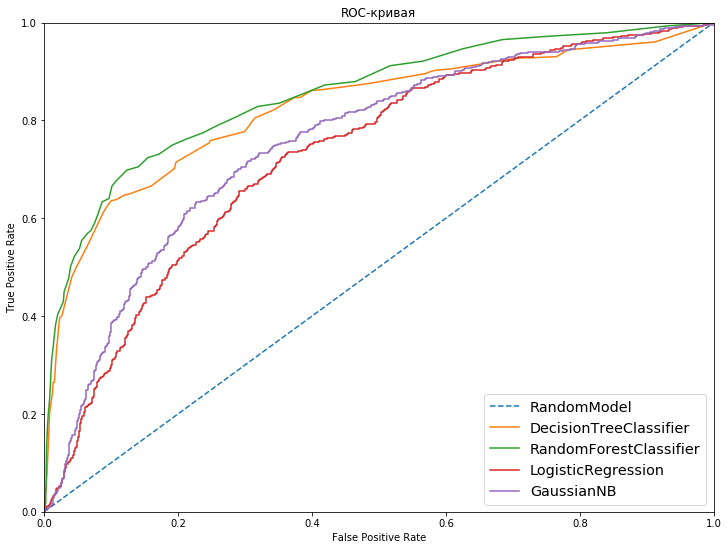

In [22]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=20052020, n_estimators=53)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = GaussianNB()
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC GaussianNB',auc_roc)
plt.plot(fpr, tpr, label='GaussianNB')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Вывод по шагу 3

Дисбаланс повлиял на модели в худшую сторону. Лучшим решением стало увеличение классов 1 в тренировочной выборке.

Выравние классов в выборке привело к резкому росту параметра recall и небольшому понижению percison. Но в целом F-мера выросла.

# 4. Тестирование модели

К тестовой выборке примем модель случайного дерева. Исследуем гиперпараметры и улучшим F-меру модели.

Начнем с гиперпараметра n_estimators.

In [23]:
%%time

for estimator in range(10, 500, 10):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid))

N estimators 10 F1 0.6143958868894602
N estimators 20 F1 0.6283524904214559
N estimators 30 F1 0.6310432569974554
N estimators 40 F1 0.6227848101265823
N estimators 50 F1 0.6290726817042607
N estimators 60 F1 0.6298619824341279
N estimators 70 F1 0.6389937106918239
N estimators 80 F1 0.641697877652934
N estimators 90 F1 0.6365914786967418
N estimators 100 F1 0.6373902132998746
N estimators 110 F1 0.6381909547738692
N estimators 120 F1 0.6397984886649875
N estimators 130 F1 0.632241813602015
N estimators 140 F1 0.6415094339622641
N estimators 150 F1 0.6397984886649875
N estimators 160 F1 0.6415094339622641
N estimators 170 F1 0.6398996235884568
N estimators 180 F1 0.6392009987515606
N estimators 190 F1 0.6390977443609023
N estimators 200 F1 0.6399999999999999
N estimators 210 F1 0.6376089663760897
N estimators 220 F1 0.6416040100250625
N estimators 230 F1 0.6389937106918239
N estimators 240 F1 0.6397984886649875
N estimators 250 F1 0.6407035175879398
N estimators 260 F1 0.63659147869674

Лучший результат лежит в диапазоне 370-390.

In [24]:
%%time

for estimator in range(370, 391):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid))

N estimators 370 F1 0.642409033877039
N estimators 371 F1 0.6433041301627035
N estimators 372 F1 0.6441102756892231
N estimators 373 F1 0.6450000000000001
N estimators 374 F1 0.6474278544542033
N estimators 375 F1 0.6458072590738423
N estimators 376 F1 0.6457286432160804
N estimators 377 F1 0.6457286432160804
N estimators 378 F1 0.6457286432160804
N estimators 379 F1 0.644918444165621
N estimators 380 F1 0.6457286432160804
N estimators 381 F1 0.644918444165621
N estimators 382 F1 0.6440251572327044
N estimators 383 F1 0.644918444165621
N estimators 384 F1 0.644918444165621
N estimators 385 F1 0.6466165413533834
N estimators 386 F1 0.6474278544542033
N estimators 387 F1 0.6483103879849811
N estimators 388 F1 0.6440251572327044
N estimators 389 F1 0.6457286432160804
N estimators 390 F1 0.6423173803526449
CPU times: user 1min 50s, sys: 832 ms, total: 1min 51s
Wall time: 1min 51s


Лучший F1 при n_estimators = 387

In [25]:
%%time

model =  RandomForestClassifier(random_state=20052020, n_estimators=387, criterion='entropy')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid))

F1 0.6432160804020101
CPU times: user 7.27 s, sys: 36 ms, total: 7.31 s
Wall time: 7.33 s


Изменим гиперпараметр min_samples_split.

In [26]:
%%time

for samples_split in range(1, 11):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=samples_split/10)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('Samples_split', samples_split/10,'F1', f1_score(target_valid, predicted_valid))
    
for samples_split in range(2, 11):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=samples_split)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('Samples_split', samples_split,'F1', f1_score(target_valid, predicted_valid))

Samples_split 0.1 F1 0.6012715712988193
Samples_split 0.2 F1 0.5915996425379804
Samples_split 0.3 F1 0.5758091993185691
Samples_split 0.4 F1 0.5750421585160204
Samples_split 0.5 F1 0.5808124459809852
Samples_split 0.6 F1 0.5724020442930153
Samples_split 0.7 F1 0.3545865898807075
Samples_split 0.8 F1 0.3545865898807075
Samples_split 0.9 F1 0.3545865898807075
Samples_split 1.0 F1 0.3545865898807075
Samples_split 2 F1 0.6423173803526449
Samples_split 3 F1 0.643939393939394
Samples_split 4 F1 0.6415094339622641
Samples_split 5 F1 0.652605459057072
Samples_split 6 F1 0.6411837237977804
Samples_split 7 F1 0.6513317191283292
Samples_split 8 F1 0.6370192307692308
Samples_split 9 F1 0.6476190476190476
Samples_split 10 F1 0.6508313539192399
CPU times: user 1min 3s, sys: 232 ms, total: 1min 3s
Wall time: 1min 3s


Лучший F1 получени при min_samples_split=5.

Изменим гиперпараметр min_samples_leaf.

In [27]:
%%time

for samples_leaf in range(1, 6):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5, 
                                    min_samples_leaf= samples_leaf/10)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('Samples_leaf', samples_leaf/10,'F1', f1_score(target_valid, predicted_valid))
    
for samples_leaf in range(1, 11):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf= samples_leaf)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('Samples_leaf', samples_leaf,'F1', f1_score(target_valid, predicted_valid))

Samples_leaf 0.1 F1 0.5557522123893804
Samples_leaf 0.2 F1 0.5449781659388646
Samples_leaf 0.3 F1 0.5159744408945686
Samples_leaf 0.4 F1 0.3545865898807075
Samples_leaf 0.5 F1 0.3545865898807075
Samples_leaf 1 F1 0.652605459057072
Samples_leaf 2 F1 0.6461538461538461
Samples_leaf 3 F1 0.6461187214611872
Samples_leaf 4 F1 0.6607142857142857
Samples_leaf 5 F1 0.659316427783903
Samples_leaf 6 F1 0.6579520697167756
Samples_leaf 7 F1 0.6644951140065147
Samples_leaf 8 F1 0.655982905982906
Samples_leaf 9 F1 0.6567164179104478
Samples_leaf 10 F1 0.6527632950990615
CPU times: user 56.9 s, sys: 148 ms, total: 57.1 s
Wall time: 57.2 s


Лучший показатель min_samples_leaf = 7

Проверим на тестовой выборке четыре модели: на дисбалансных данных и сбалансированных: со взвешенными классами, усечением 0 класса и расширением класса 1.

In [28]:
model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Случайный лес - дисбаланс классов')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Случайный лес - взвешенные классы')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
print('Случайный лес - уменьшенное количество классов 0')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print('Случайный лес - увеличенное количество классов 1')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

Случайный лес - дисбаланс классов
Точность попадания по классам 0.866
Precision 0.7931034482758621
Recall 0.45544554455445546
F1 0.578616352201258

Случайный лес - взвешенные классы
Точность попадания по классам 0.834
Precision 0.5796460176991151
Recall 0.6485148514851485
F1 0.6121495327102804

Случайный лес - уменьшенное количество классов 0
Точность попадания по классам 0.768
Precision 0.4541284403669725
Recall 0.7351485148514851
F1 0.5614366729678638

Случайный лес - увеличенное количество классов 1
Точность попадания по классам 0.8205
Precision 0.5456389452332657
Recall 0.6658415841584159
F1 0.5997770345596434



AUC-ROC RandomForestClassifier - disbalanced 0.862183304796645
AUC-ROC RandomForestClassifier - balanced by class weight 0.8613411623117199
AUC-ROC RandomForestClassifier - balanced by reduce 0 class 0.8566279560286857
AUC-ROC RandomForestClassifier - balanced by grow 1 class 0.8586394823692896


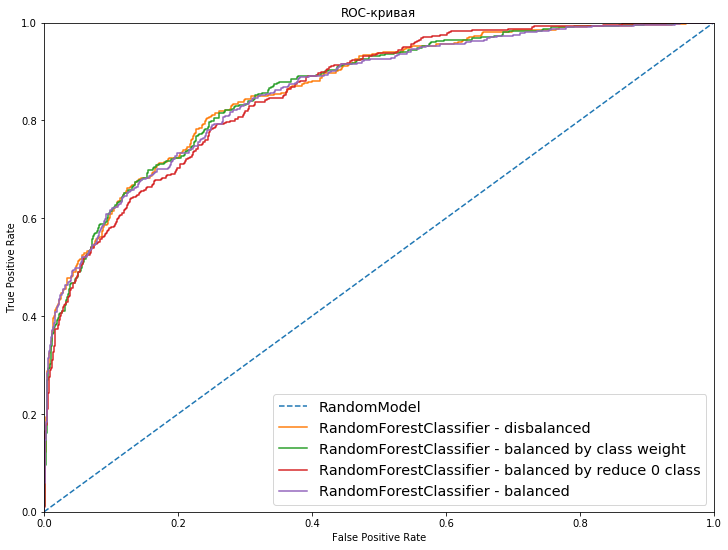

In [29]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - disbalanced',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - disbalanced')

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by class weight',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by class weight')

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by reduce 0 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by reduce 0 class')

model = RandomForestClassifier(random_state=20052020, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by grow 1 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Вывод по шагу 4

2 из 4 моделей достигли минимума F-меры на тестовых данных: модель случайного леса со взвешенными весами классов и модель с увеличенным количеством класса 1.

Видно, что взвешивание классов дает результат лучше для данного набора данных. Percision падает, recall растет, и в целом F-мера имеет небольшой прирост. Баланс классов повышает охват необходимых данных.

Оценивая адеватность модели можно заметить, что AUC-ROC дисбалансной модели и модели с весами примерно одинаково предсказывают вероятность ухода клиента.

В результате исследования была получена модель с лучшими показателями как по F1-мере, так и по AUC-ROC - Случайный лес: взвешенные классы.

## Итоговый вывод

При работе с проектом было выполнено:

1. Изучены данные. Разбиты данные на тренировочную, валидационную и тестовую выборку.
2. Исследована задача. Проверены модели на данных без изменений.
3. Скоректирован балланс класса. Изменен вес класса.
4. Получена улученная модель. Проведен поиск гиперпараметров.
5. Проведен финальный тест.

Обученная модель случайного леса со взвешенными классами имеет достаточную адекватность, подтвержденная ее значением AUC-ROC = 0.861. Это лучше, чем случайная модель предсказывания (AUC-ROC = 0.5). Точность попадания по классам 0.834, precision 0.58, recall 0.649 и f1 0.612. Модель старается собрать больше данных, чем показать верную точность (recall > precision). Процент попадания в классы достаточно высокий.